In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from pingouin import welch_anova, pairwise_tukey
import statsmodels.formula.api as smf

### Resumo

A seguradora para a qual você está trabalhando recentemente coletou um conjunto de dados de seus clientes que inclui informações como idade, sexo, índice de massa corporal (IMC), número de dependentes, hábito de fumar e região de residência. Com base nesses dados, a seguradora deseja prever os custos médicos futuros de seus clientes para melhorar suas estimativas financeiras e otimizar suas políticas de cobertura.
- Como cientista de dados da equipe, seu papel é desenvolver um modelo preditivo para alcançar esse objetivo.

#### **Cleaning**

In [16]:

df = pd.read_csv('../../data/09. TCC/custos/insurance.csv')

#### **EDA**

In [17]:

print(df.shape)
display(
    pd.DataFrame({
        'Tipo': df.dtypes,
        'Qtde nulos': df.isnull().sum(),
        'Proporção nulos': df.isnull().mean(),
        'Qtde unicos': df.nunique(),
        'Exemplo unicos': df.apply(lambda x: x.unique()[:3])
    })
)

(1338, 7)


,Tipo,Qtde nulos,Proporção nulos,Qtde unicos,Exemplo unicos
age,int64,0,0.0,47,"[19, 18, 28]"
sex,object,0,0.0,2,"[female, male]"
bmi,float64,0,0.0,548,"[27.9, 33.77, 33.0]"
children,int64,0,0.0,6,"[0, 1, 3]"
smoker,object,0,0.0,2,"[yes, no]"
region,object,0,0.0,4,"[southwest, southeast, northwest]"
charges,float64,0,0.0,1337,"[16884.924, 1725.5523, 4449.462]"


##### **analise univariada**

In [39]:

df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


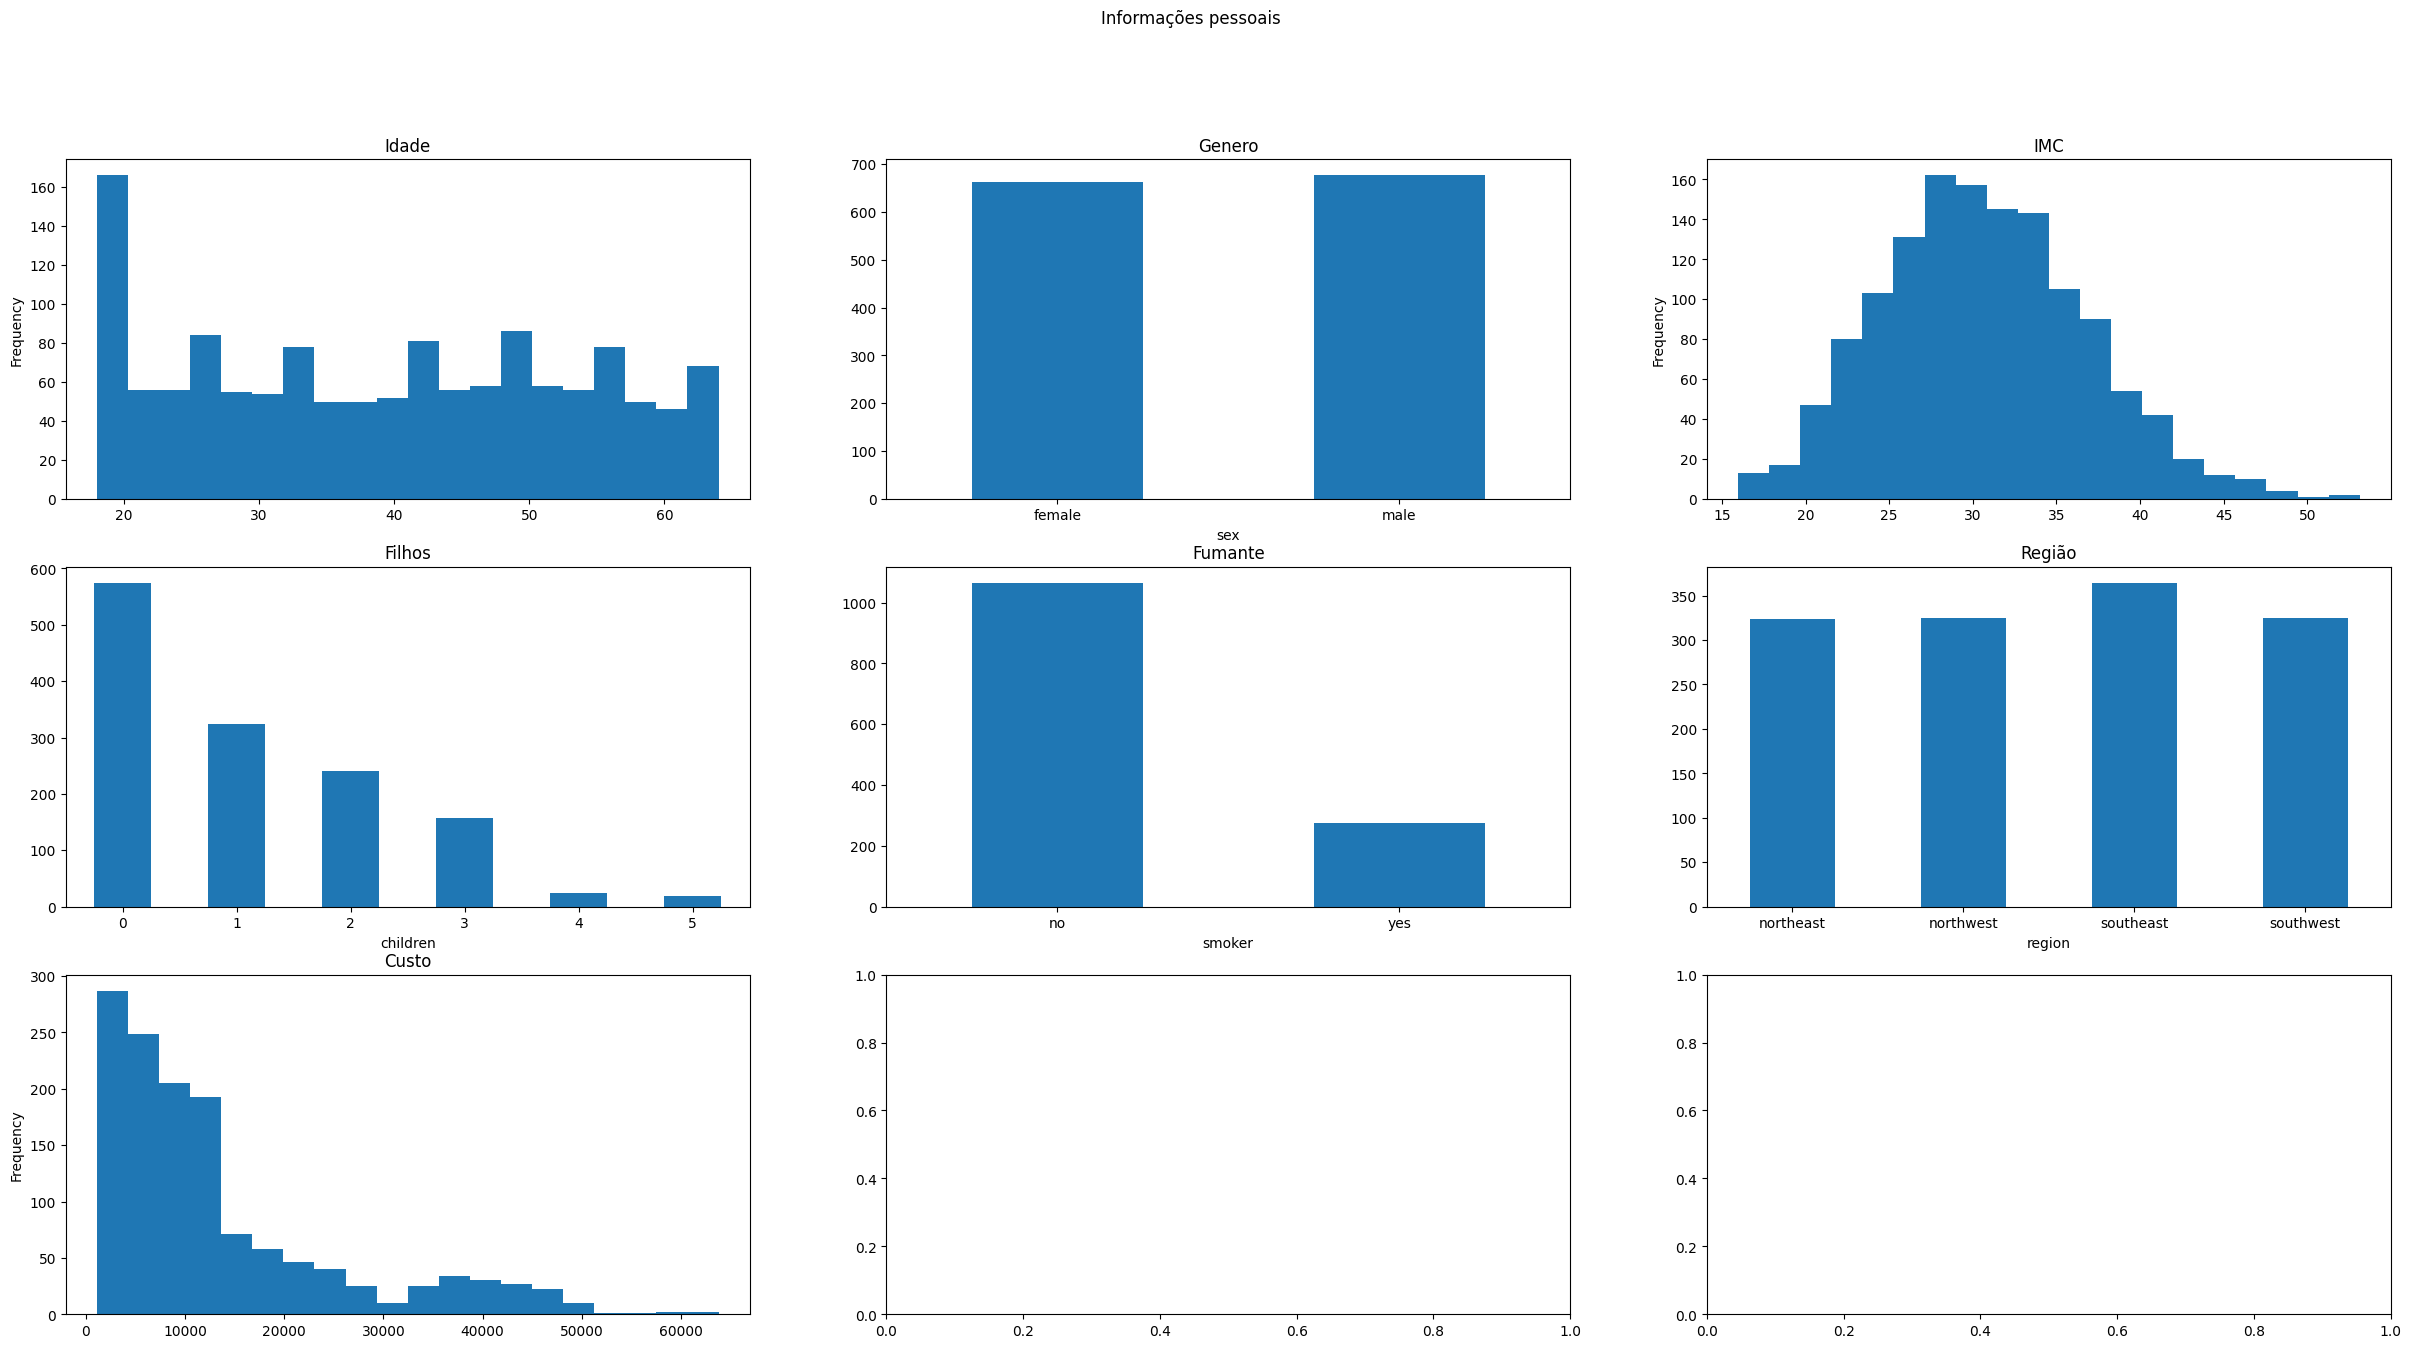

In [50]:

fig, axs = plt.subplots(3, 3, figsize=(30, 15))

df['age'].plot.hist(ax=axs[0, 0], bins=20)
axs[0, 0].set_title('Idade')

df.groupby('sex')['age'].count().plot.bar(ax=axs[0, 1])
axs[0, 1].set_title('Genero')
axs[0, 1].tick_params(axis='x', labelrotation=0)

df['bmi'].plot.hist(ax=axs[0, 2], bins=20)
axs[0, 2].set_title('IMC')

df.groupby('children')['age'].count().plot.bar(ax=axs[1, 0])
axs[1, 0].set_title('Filhos')
axs[1, 0].tick_params(axis='x', labelrotation=0)

df.groupby('smoker')['age'].count().plot.bar(ax=axs[1, 1])
axs[1, 1].set_title('Fumante')
axs[1, 1].tick_params(axis='x', labelrotation=0)

df.groupby('region')['age'].count().plot.bar(ax=axs[1, 2])
axs[1, 2].set_title('Região')
axs[1, 2].tick_params(axis='x', labelrotation=0)

df['charges'].plot.hist(ax=axs[2, 0], bins=20)
axs[2, 0].set_title('Custo')

plt.suptitle('Informações pessoais')
plt.show()

*insights:* 
- idade: maioria das pessoas possuem pouco menos ou igual a 20 anos, após isso a distribuição é quase uniforme até pouco mais que 60 anos.
- genêro: pessoas bem distribuidas entre feminino e masculino.
- IMC: segue uma distribuição perto de uma normal com média = 30.
- filhos: maioria das pessoas possuem zero filhos e a proporção diminui suavemente até 5 filhos.
- fumante: maioria das pessoas não possuem filhos.
- região: pessoas bem distribuidas entre as regiões.
- custo: maioria das pessoas possuem baixo custo e a proporção diminui suavemente até 10k+ até cair abruptamente e depois diminir suavemente até 60k+.

##### **analise bivariada** - versus charges

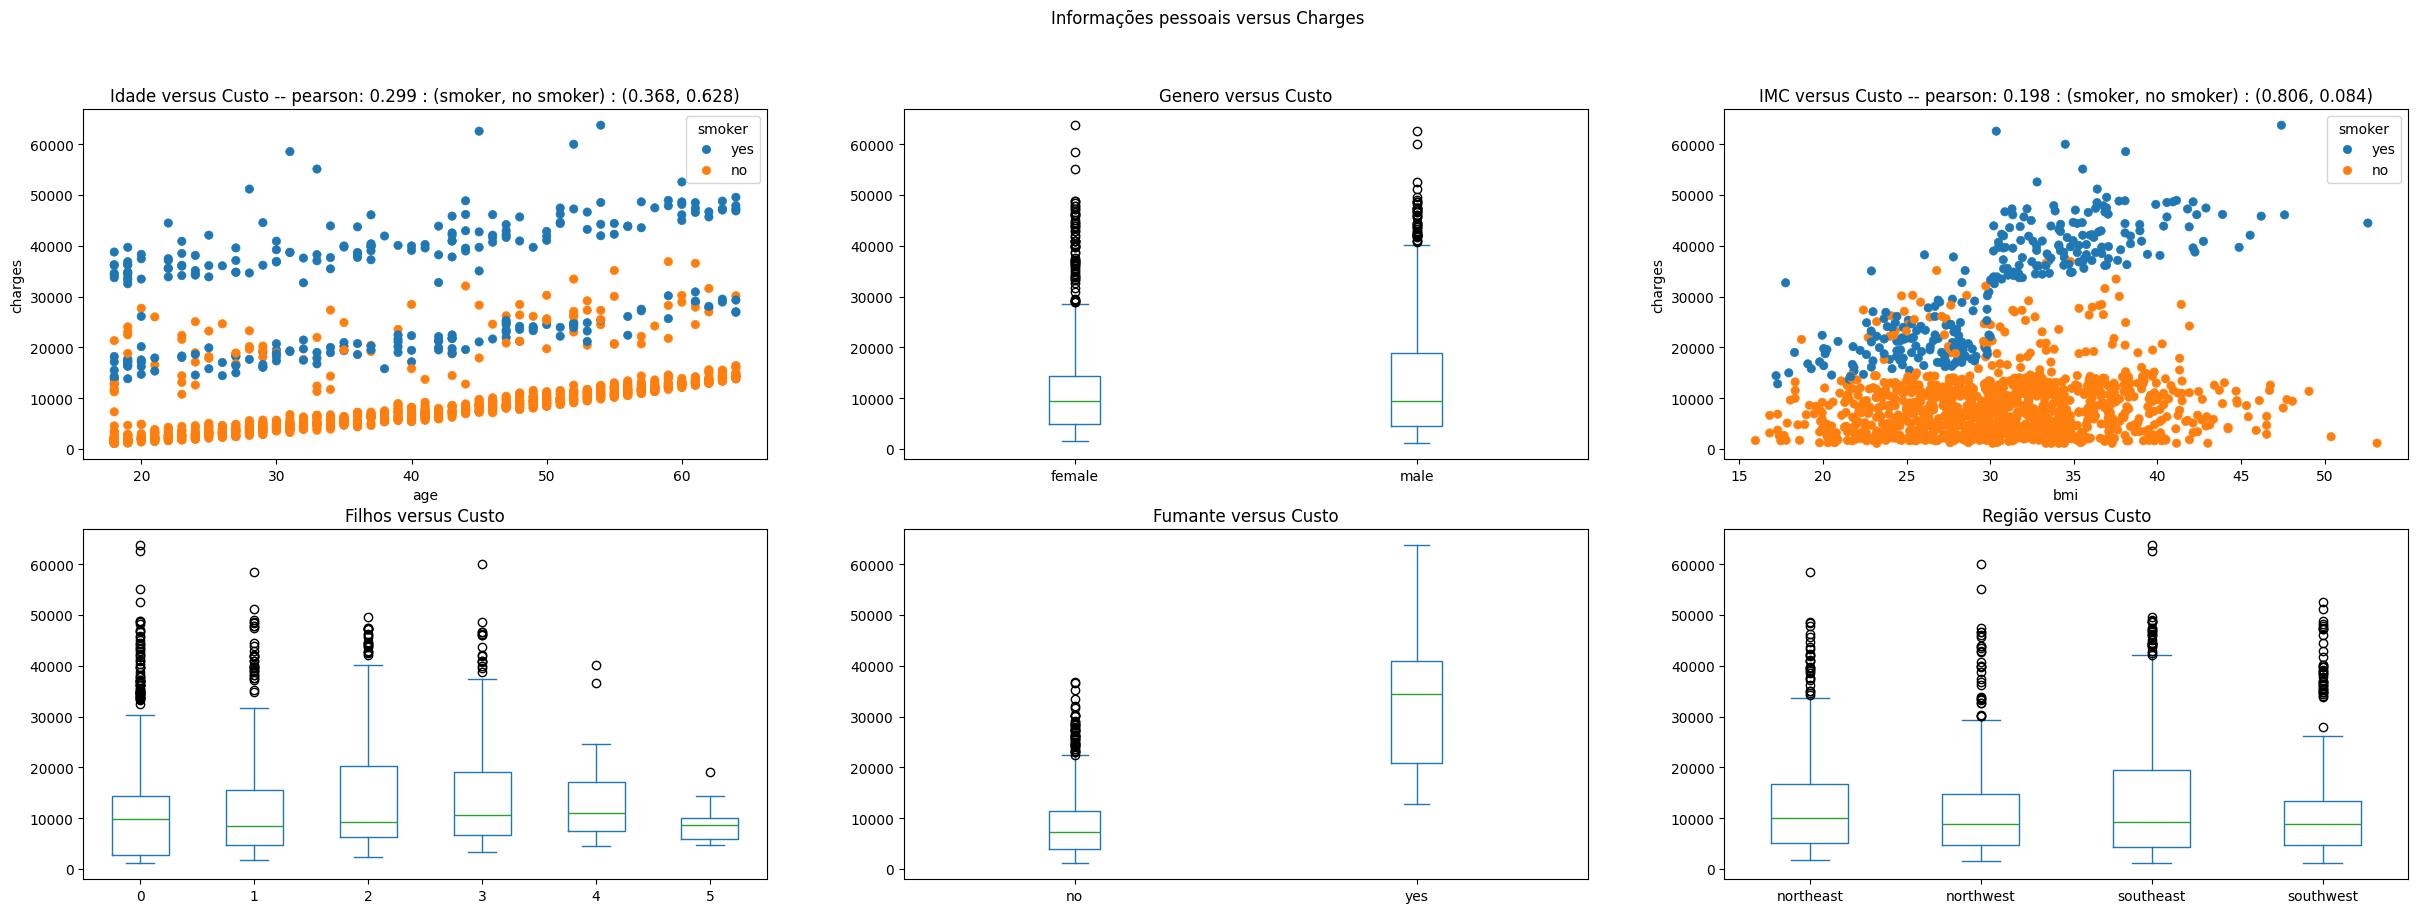

In [152]:

fig, axs = plt.subplots(2, 3, figsize=(30, 10))

sns.scatterplot(x='age', y='charges', data=df, hue='smoker', ec=None, ax=axs[0, 0])
corr = float(round(df[['age','charges']].corr().values[0, 1], 3))
smoker_corr = float(round(df[df['smoker'] == 'yes'][['age','charges']].corr().values[0, 1], 3))
no_smoker_corr = float(round(df[df['smoker'] == 'no'][['age','charges']].corr().values[0, 1], 3))
axs[0, 0].set_title(f"Idade versus Custo -- pearson: {corr} : (smoker, no smoker) : ({smoker_corr}, {no_smoker_corr})")

df[['sex','charges']].plot.box(by='sex', ax=axs[0, 1])
# sns.boxplot(data=df, x='sex', y='charges', hue='smoker', ax=axs[0, 1])
axs[0, 1].set_title('Genero versus Custo')
axs[0, 1].tick_params(axis='x', labelrotation=0)

sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker', ec=None, ax=axs[0, 2])
corr = float(round(df[['bmi','charges']].corr().values[0, 1], 3))
smoker_corr = float(round(df[df['smoker'] == 'yes'][['bmi','charges']].corr().values[0, 1], 3))
no_smoker_corr = float(round(df[df['smoker'] == 'no'][['bmi','charges']].corr().values[0, 1], 3))
axs[0, 2].set_title(f"IMC versus Custo -- pearson: {corr} : (smoker, no smoker) : ({smoker_corr}, {no_smoker_corr})")

df[['children','charges']].plot.box(by='children', ax=axs[1, 0])
# sns.boxplot(data=df, x='children', y='charges', hue='smoker', ax=axs[1, 0])
axs[1, 0].set_title('Filhos versus Custo')
axs[1, 0].tick_params(axis='x', labelrotation=0)

df[['smoker','charges']].plot.box(by='smoker', ax=axs[1, 1])
axs[1, 1].set_title('Fumante versus Custo')
axs[1, 1].tick_params(axis='x', labelrotation=0)

df[['region','charges']].plot.box(by='region', ax=axs[1, 2])
# sns.boxplot(data=df, x='region', y='charges', hue='smoker', ax=axs[1, 2])
axs[1, 2].set_title('Região versus Custo')
axs[1, 2].tick_params(axis='x', labelrotation=0)

plt.suptitle('Informações pessoais versus Charges')
plt.show()

In [144]:

a = .05

print('-- Idade')
print(f"-> correlação entre Idade e Custo: {float(round(df[['age','charges']].corr().values[0, 1], 3))}")
print('** sob implicação de Fumante **')
print(f"-> correlação entre Idade (não fumante) e Custo: {float(round(df[df['smoker'] == 'no'][['age','charges']].corr().values[0, 1], 3))}")
print(f"-> correlação entre Idade (fumante) e Custo: {float(round(df[df['smoker'] == 'yes'][['age','charges']].corr().values[0, 1], 3))}")

print()
print('-- Genero')
display(df.groupby('sex')['charges'].mean().sort_values().reset_index(name='MEAN'))

# teste de hipoteses para 2 médias com var populacional desconhecidas e suspostamente diferentes. T-Student Welch
t_stat, p_value = ttest_ind( # h0: m1 = m2 (estatisticamente)
    df[df['sex']=='female']['charges'].values, 
    df[df['sex']=='male']['charges'].values, 
    equal_var=False) 
print('->', '' if p_value <= a else 'não', f'existe diferença estatistica entre as médias a um intervalo de confiança de {1-a}.', f'p-value = {p_value}')

print()
print('-- IMC')
print(f"-> correlação entre Idade e Custo: {float(round(df[['bmi','charges']].corr().values[0, 1], 3))}")
print('** sob implicação de Fumante **')
print(f"-> correlação entre Idade (não fumante) e Custo: {float(round(df[df['smoker'] == 'no'][['bmi','charges']].corr().values[0, 1], 3))}")
print(f"-> correlação entre Idade (fumante) e Custo: {float(round(df[df['smoker'] == 'yes'][['bmi','charges']].corr().values[0, 1], 3))}")

print()
print('-- Filhos')
display(df[['children', 'charges']].groupby('children')['charges'].mean().sort_values().reset_index(name='MEAN'))
# teste de hipoteses para 3+ médias com var populacional desconhecidas e suspostamente diferentes. ANOVA Welch
p_value = welch_anova(dv='charges', between='children', data=df).values[0, 4] # h0: medias iguais (estatisticamente)
print('->', '' if p_value <= a else 'não', f'existe pelo menos 1 média estatistica diferente a outras a um intervalo de confiança de {1-a}.', f'p-value = {p_value}')

# ... já que existe pelo menos 1 média diferente a outras, teste de hipoteses POST-HOC ~ pair wise Tukey entre as médias.
df_pairwise = pairwise_tukey(dv='charges', between='children', data=df)
print('-> médias estatisticamente diferentes:')
display(df_pairwise[df_pairwise['p-tukey'] <= a])

print()
print('-- Fumante')
display(df.groupby('smoker')['charges'].mean().sort_values().reset_index(name='MEAN'))

# teste de hipoteses para 2 médias com var populacional desconhecidas e suspostamente diferentes. T-Student Welch
t_stat, p_value = ttest_ind( # h0: m1 = m2 (estatisticamente)
    df[df['smoker']=='yes']['charges'].values, 
    df[df['smoker']=='no']['charges'].values, 
    equal_var=False) 
print('->', '' if p_value <= a else 'não', f'existe diferença estatistica entre as médias a um intervalo de confiança de {1-a}.', f'p-value = {p_value}')

print()
print('-- Região')
display(df[['region', 'charges']].groupby('region')['charges'].mean().sort_values().reset_index(name='MEAN'))
# teste de hipoteses para 3+ médias com var populacional desconhecidas e suspostamente diferentes. ANOVA Welch
p_value = welch_anova(dv='charges', between='region', data=df).values[0, 4] # h0: medias iguais (estatisticamente)
print('->', '' if p_value <= a else 'não', f'existe pelo menos 1 média estatistica diferente a outras a um intervalo de confiança de {1-a}.', f'p-value = {p_value}')

-- Idade
-> correlação entre Idade e Custo: 0.299
** sob implicação de Fumante **
-> correlação entre Idade (não fumante) e Custo: 0.628
-> correlação entre Idade (fumante) e Custo: 0.368

-- Genero


,sex,MEAN
0,female,12569.578844
1,male,13956.751178


->  existe diferença estatistica entre as médias a um intervalo de confiança de 0.95. p-value = 0.03584101495601664

-- IMC
-> correlação entre Idade e Custo: 0.198
** sob implicação de Fumante **
-> correlação entre Idade (não fumante) e Custo: 0.084
-> correlação entre Idade (fumante) e Custo: 0.806

-- Filhos


,children,MEAN
0,5,8786.035247
1,0,12365.975602
2,1,12731.171832
3,4,13850.656311
4,2,15073.563734
5,3,15355.318367


->  existe pelo menos 1 média estatistica diferente a outras a um intervalo de confiança de 0.95. p-value = 1.0507578441888616e-05
-> médias estatisticamente diferentes:


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
1,0,2,12365.975602,15073.563734,-2707.588132,926.910687,-2.921088,0.041294,-0.220191



-- Fumante


,smoker,MEAN
0,no,8434.268298
1,yes,32050.231832


->  existe diferença estatistica entre as médias a um intervalo de confiança de 0.95. p-value = 5.88946444671698e-103

-- Região


,region,MEAN
0,southwest,12346.937377
1,northwest,12417.575374
2,northeast,13406.384516
3,southeast,14735.411438


-> não existe pelo menos 1 média estatistica diferente a outras a um intervalo de confiança de 0.95. p-value = 0.05059276321931547


*insights:*
- idade: não existe uma correlação forte entre Idade e Custo por si só. porem analisando como Fumante implica tal correlação descobrimos que Idade+Fumante versus Custo possui uma correlação de Pearson quase forte de .628.
- genero: existe diferença significativa as médias de Custo por Genero, onde masculino tem uma média maior. analisando como Fumante implica tal diferença vemos que a diferença só existe quando analisamos Fumante.
- IMC: não existe uma correlação forte entre IMC e Custo por si só. porem analisando como Fumante implica tal correlação descobrimos que IMC+Fumante versus Custo possui uma correlação de Pearson forte de .806.
- filhos: existe diferença significativa apenas entre duas médias em Filhos, que é entre 0 Filhos versus 2 Filhos.
- fumante: existe diferença MUITO significativa entre as médias de Fumante (yes versus no).
- região: não existe diferença significativa entre as médias para Região. porem a diferença passa a existir quando analisamos Região+Fumante.

*pertinente:* Grande chance de a feature Fumante ser a mais impactante contra Custo.

##### **analise multivariada** | Regressão Linear - versus charges

In [158]:
df_rl = df.copy()

print('dummies')
dummies_cols = ['sex', 'smoker', 'region']
for col in dummies_cols:
    print(f"default for {col}: {df_rl[col].unique()[0]}")
    for val in df_rl[col].unique()[1:]:
        col_name = f"{col}_{val.replace(' ','_').replace('-','_')}_"
        df_rl[col_name] = (df_rl[col] == val).astype(int)
    df_rl = df_rl.drop(col, axis=1)

display(df_rl.sample().iloc[0])

dummies
default for sex: female
default for smoker: yes
default for region: southwest


age                     63.0000
bmi                     21.6600
children                 0.0000
charges              14449.8544
sex_male_                0.0000
smoker_no_               1.0000
region_southeast_        0.0000
region_northwest_        0.0000
region_northeast_        1.0000
Name: 1236, dtype: float64

###### modelo A - para inferencia dos coeficientes

In [ ]:
target = 'charges'
features = [col for col in df_rl.columns if target not in col]

formula = f"{target} ~ {' + '.join(features)}"
model = smf.ols(formula=formula, data=df_rl)
res = model.fit()
summary = res.summary()
summary

### Omnibus 
# h0: todos os coeficientes (excluindo o interpecto) são iguais a zero, i.e., são insignificantes -> modelo irrelevante.
# ha: pelo menos 1 coeficiente é diferente de zero, i.e., pelo menos 1 coeficiente significante -> modelo não irrelevante.
### Jarque-Bera h0: 
# h0: distribuição dos residuos seguem uma normal.
# ha: distribuição dos residuos não seguem uma normal.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        10:46:32   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.095e+04   1069.948     10.234      0.000    8850.974     1.3e+04
age                 256.8564     11.899     21.587      0.000     233.514     280.199
bmi                 339.1935     28.599     11.860      0.000     283.088     395.298
children            475.5005    137.804      3.451      0.001     205.163     745.838
sex_male_          -131.3144    332.945     -0.394      0.693    -784.470     521.842
smoker_no_        -2.385e+04    413.153    -57.723      0.000   -2.47e+04    -2.3e+04
region_southeast_   -74.9711    470.639     -0.159      0.873    -998.247     848.305
region_northwest_   607.0871    477.204      1.272      0.204    -329.068    1543.242
region_northeast_   960.0510    477.933      2.009      0.045      22.466    1897.636
==============================================================================
Omnibus:                      300.366   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              718.887
Skew:                           1.211   Prob(JB):                    7.86e-157
Kurtosis:                       5.651   Cond. No.                         343.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###### modelo B - para previsão

In [14]:
...

Ellipsis